# Packages

In [ ]:
##uncomment to install libraries
!pip install gputil
!pip install psutil
!pip install humanize

In [ ]:
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# torchvision
import torchvision
import torchvision.transforms.v2 as transforms

# plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix

# utils
import time
import numpy as np
import os
import copy

##gpu
import psutil
import humanize
import GPUtil as GPU

In [ ]:
##to find out about the information for computational requirements for the gpu

GPUs = GPU.getGPUs()

if GPUs:
    gpu = GPUs[0]  # only picked one gpu, we only had one available
    print(f"GPU Name: {gpu.name}")
    print(f"GPU Driver: {gpu.driver}")
    print(f"GPU Memory Total: {humanize.naturalsize(gpu.memoryTotal)}")
    print(f"GPU Memory Free: {humanize.naturalsize(gpu.memoryFree)}")
    print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")
else:
    print("No GPU available.")

# CPU information
print(f"\nCPU Cores: {psutil.cpu_count(logical=False)}")
print(f"CPU Threads: {psutil.cpu_count(logical=True)}")

GPU Name: Tesla T4
GPU Driver: 525.105.17
GPU Memory Total: 15.4 kB
GPU Memory Free: 11.7 kB
GPU Memory Used: 3.5 kB

CPU Cores: 1
CPU Threads: 2


In [ ]:
!nvidia-smi

Sun Nov 19 19:58:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Data

In [ ]:
if os.path.exists("./data/cifar-100-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=download, transform=transforms.ToTensor()
)
dataset_test = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=download, transform=transforms.ToTensor()
)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [ ]:
cifar100_mean = np.mean(dataset_train.data / 255.0, axis=(0, 1, 2))
cifar100_std = np.std(dataset_train.data / 255.0, axis=(0, 1, 2))
transform = transforms.Compose(
    [
        # first cast the data to a pytorch tensor
        transforms.ToTensor(),
        # then define mean and std for the normalization (RMK: for each channel)
        # output[channel] = (input[channel] - mean[channel]) / std[channel]
        transforms.Normalize(mean=cifar100_mean, std=cifar100_std),
    ]
)

if os.path.exists("./data/cifar-100-python.tar.gz") == False:
    download = True
else:
    download = False

dataset_train = torchvision.datasets.CIFAR100(
    root="./data", train=True, download=download, transform=transform
)
dataset_test = torchvision.datasets.CIFAR100(
    root="./data", train=False, download=download, transform=transform
)

classes = dataset_train.classes

## Training dataset split

In [ ]:
torch.manual_seed(42)
# This just splits the indices into two subsets basically
train_subset, val_subset = torch.utils.data.random_split(dataset_train, [0.8, 0.2])

## Data loaders

In [ ]:
batch_size = 128  # hyperparameter
trainloader = torch.utils.data.DataLoader(
    train_subset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True
)
valloader = torch.utils.data.DataLoader(
    val_subset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)
testloader = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True
)

# Model

In [ ]:
class VGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(VGG13, self).__init__()
        self.batch_norm = batch_norm

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Training

### Utils

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda:0


In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta  # minimum improvement to reset patience
        self.restore_best_weights = restore_best_weights
        self.best_model = None
        self.best_loss = None
        self.counter = 0
        self.status = ""

    def __call__(self, model, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = copy.deepcopy(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model.load_state_dict(model.state_dict())
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.status = f"Stopped on {self.counter}"
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model.state_dict())
                return True
        self.status = f"{self.counter}/{self.patience}"
        return False

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 19:58:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    30W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Train loop

In [ ]:
def train_model(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = 0
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                accuracy = correct / total
                training_loss.append(running_loss / tot_samples)
                training_accuracy.append(accuracy)
                print(
                    f"Epoch {epoch + 1}"
                    + f"\tTraining loss: {loss.item():.6f}"
                    + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                    + f"\tTraining partial incremental accuracy: {accuracy * 100:.2f}"
                )
                running_loss = 0
                tot_samples = 0
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = 0
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                _, pred = torch.max(output, dim=1)
                correct += (pred == target).sum().item()
                total += batch_size
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    # calculate the batch loss
                    accuracy = correct / total
                    validation_loss.append(running_loss / tot_samples)
                    validation_accuracy.append(accuracy)
                    print(
                        f"Epoch {epoch + 1}"
                        + f"\tValidation loss: {loss:.6f}"
                        + f"\tRunning loss: {running_loss / tot_samples:.6f}"
                        + f"\tAccuracy: {accuracy * 100:.2f}"
                    )
                    running_loss = 0
                    tot_samples = 0

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
vgg = VGG13(num_classes=100)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    vgg.parameters(),
    lr=0.0005,
)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 30

vgg = vgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model(
    vgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 4.609130	Running loss: 4.607115	Training partial incremental accuracy: 0.00
Epoch 1	Training loss: 4.605989	Running loss: 4.606933	Training partial incremental accuracy: 0.00
Epoch 1	Training loss: 4.404168	Running loss: 4.494202	Training partial incremental accuracy: 1.56
Epoch 1	Training loss: 4.246048	Running loss: 4.345216	Training partial incremental accuracy: 2.34
Epoch 1	Training loss: 4.252457	Running loss: 4.273679	Training partial incremental accuracy: 2.50
Epoch 1	Validation loss: 4.122570	Running loss: 4.277087	Accuracy: 3.54
Epoch 1	Validation loss: 4.164416	Running loss: 4.270953	Accuracy: 3.67
Epoch 1	Validation loss: 4.176249	Running loss: 4.252032	Accuracy: 3.94
Epoch 1	Validation loss: 4.287363	Running loss: 4.290035	Accuracy: 3.82
Epoch 1	Validation loss: 4.210291	Running loss: 4.242692	Accuracy: 3.61
Epoch 2	Training loss: 4.237348	Running loss: 4.207881	Training partial incremental accuracy: 6.25
Epoch 2	Training loss: 4.136752	Running loss: 

### Test

In [ ]:
# test accuracy
vgg.eval()
correct = 0
total = 0

start = time.time()
with torch.no_grad():
    for data, target in testloader:
        # move tensors to GPU if CUDA is available
        data = data.to(device)
        target = target.to(device)
        # forward pass
        output = vgg(data)
        _, pred = torch.max(output, dim=1)
        total += target.size(0)
        correct += (pred == target).sum().item()
end = time.time()

print(f"Test accuracy: {correct / total * 100:.2f}%")
print(f"Test took {end - start:.2f} seconds")

Test accuracy: 32.31%
Test took 3.30 seconds


### Inference time test

In [ ]:
vgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    start = time.time()
    output = vgg(img)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Output: {output}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00404143 seconds
Output: tensor([[ -0.3412,   7.2044,  -5.5786,  -2.6907, -11.6691,  -8.9338,  -4.9270,
          -1.9146,  -6.9643, -11.5218,  -4.8656,  -4.6860, -11.7422,  -6.9710,
           2.1061, -10.3348,  -9.8304, -18.0908,  -2.3347,  -6.5686,  -8.5957,
         -13.8672, -11.8203,  -5.6385,  -7.9118,  -7.1852,   0.7280,  -6.0970,
          -9.9769,  -3.3538, -20.6401, -17.9683,  -7.8688,  -6.1766,  -3.8299,
          -8.2453,  -8.5830, -11.9437,  -4.5113,  -4.6857,  -7.1865,   2.1128,
         -12.3055, -11.8542,  -4.3727,  -1.8261,  -8.5336,  -9.0037,  -7.5373,
          -9.3685,  -4.9637,   2.3680, -23.0635,   0.7498,   2.6075, -10.2244,
         -13.0523,  -2.8642,  -7.8210, -11.3214, -12.2372, -16.4292,   1.3317,
         -13.9511,  -9.6108,  -6.0942,  -7.6100,  -8.2034, -13.3788,  -9.8181,
           2.2215,  -7.9204,  -7.6715,  -7.6487,  -3.8753, -10.0954, -10.3156,
          -4.1448,  -2.5186,  -5.2436, -11.5989, -13.2713,  -1.0248,  -1.1435,
          

In [ ]:
#to check memory usage and gpu status
!nvidia-smi


Sun Nov 19 20:03:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    31W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

Text(0, 0.5, 'Loss')

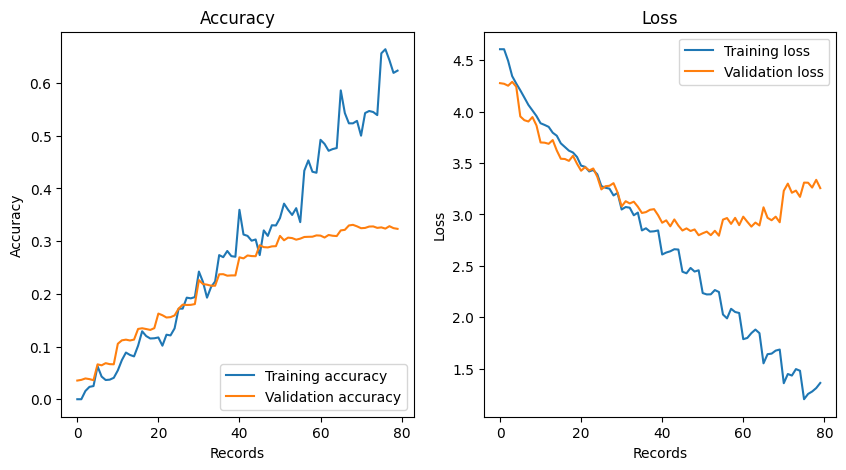

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(training_accuracy, label="Training accuracy")
axs[0].plot(validation_accuracy, label="Validation accuracy")
axs[0].legend(loc="lower right")
axs[0].set_title("Accuracy")
axs[0].set_xlabel("Records")
axs[0].set_ylabel("Accuracy")

axs[1].plot(training_loss, label="Training loss")
axs[1].plot(validation_loss, label="Validation loss")
axs[1].legend(loc="upper right")
axs[1].set_title("Loss")
axs[1].set_xlabel("Records")
axs[1].set_ylabel("Loss")

### Confusion matrix

In [ ]:
def compute_confusion_matrix(model, testloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            _, pred = torch.max(output, dim=1)
            y_true.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    return confusion_matrix(y_true, y_pred, normalize="true") * 100

In [ ]:
conf_mat = compute_confusion_matrix(vgg, testloader)
print(conf_mat)

[[58.  0.  0. ...  0.  0.  0.]
 [ 0. 30.  0. ...  0.  0.  2.]
 [ 2.  0. 34. ...  0. 10.  0.]
 ...
 [ 0.  0.  1. ... 27.  0.  0.]
 [ 0.  0. 14. ...  1. 27.  0.]
 [ 1.  0.  1. ...  0.  0. 29.]]


# Early exit

## B-NET

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:04:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion

In [ ]:
def entropy(x):
    p = F.softmax(x.detach(), dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

### Model

In [ ]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [ ]:
class BVGG13(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                e += 1
            if inference:
                # x is a single image, otherwise we would have to loop over the batch dimension
                H = entropy(x_ee)
                if torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        if inference:
            return x, H, e
        return out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

### Custom loss function

In [ ]:
class JointCrossEntropy(nn.Module):
    def __init__(self):
        super(JointCrossEntropy, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, outputs, targets):
        loss = 0
        for output in outputs:
            loss += self.cross_entropy(output, targets)
        return loss

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:04:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [ ]:
def train_model_ee(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = model(data)
            # calculate the batch loss
            loss = loss_fn(output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output = model(data)
                loss = loss_fn(output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch + 1}")
            if early_stop.restore_best_weights:
                print(
                    f"Restored model trained at epoch {epoch + 1 - early_stop.counter}"
                )
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
bvgg = BVGG13(num_classes=100)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee(
    bvgg,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 43.8309	Accuracy: [20.31 16.41 14.06  6.25  3.91  5.47  3.12  2.34  2.34  1.56]
Epoch 1	Training loss: 40.3014	Accuracy: [20.7  15.23 15.62 11.33 10.16  8.2   6.64  5.47  1.56  1.56]
Epoch 1	Training loss: 38.2554	Accuracy: [23.44 15.89 15.36 12.5  10.42  8.59  7.03  5.99  2.86  3.39]
Epoch 1	Training loss: 36.3707	Accuracy: [24.8  18.55 17.97 15.04 12.7  10.74  8.79  7.23  4.88  4.88]
Epoch 1	Training loss: 34.9349	Accuracy: [26.09 20.31 19.53 17.19 14.69 12.03 10.31  8.59  5.94  5.78]
Epoch 1	Validation loss: 34.3068	Accuracy: [32.03 28.91 25.   22.66 20.31 15.62 14.06 12.5  10.16  8.59]
Epoch 1	Validation loss: 34.0872	Accuracy: [33.59 28.12 25.   21.09 20.7  16.02 14.84 12.5   9.38  7.42]
Epoch 1	Validation loss: 34.0993	Accuracy: [33.59 28.91 26.3  22.14 21.35 17.97 15.36 12.5  10.94  9.11]
Epoch 1	Validation loss: 34.5577	Accuracy: [33.01 29.3  26.95 22.46 20.7  17.38 15.62 12.89 11.13  9.18]
Epoch 1	Validation loss: 33.9093	Accuracy: [32.5  28.59 25.94 22.

### Test data

In [ ]:
# test accuracy
bvgg.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output = bvgg(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 37.26%
Test took 3.61 seconds
Exit 2 test accuracy: 40.06%
Test took 4.17 seconds
Exit 3 test accuracy: 39.18%
Test took 3.14 seconds
Exit 4 test accuracy: 40.41%
Test took 3.04 seconds
Exit 5 test accuracy: 40.64%
Test took 3.27 seconds
Exit 6 test accuracy: 40.65%
Test took 6.49 seconds
Exit 7 test accuracy: 41.05%
Test took 5.35 seconds
Exit 8 test accuracy: 42.14%
Test took 4.33 seconds
Exit 9 test accuracy: 41.98%
Test took 4.08 seconds
Exit 10 test accuracy: 40.34%
Test took 3.06 seconds
the average test accuracy is 40.339999999999996


### Inference time

In [ ]:
bvgg.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(0, len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg.set_exit_threshold(0.1)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00282192 seconds
Exit: 2
Entropy: tensor([0.0089])
Output: tensor([[-26.5062, -39.3015, -29.0876, -20.4015, -37.0737, -38.2473, -38.5362,
         -21.9563, -46.0265, -29.7949, -21.7739, -44.5065, -36.6855, -31.5960,
         -33.2951, -29.6457, -16.7728, -46.8485, -29.8823, -29.9433, -42.4203,
         -21.6803, -26.8264, -56.6114, -32.1680, -34.2097, -34.9194, -47.8015,
         -25.7252, -35.6639, -54.9948, -26.5341, -33.7662, -30.2011, -32.3398,
         -35.5388, -44.1264, -37.0056, -31.9106, -30.7000, -27.5482, -42.0398,
         -35.6342, -33.6582, -34.9965, -32.9646, -31.4105, -48.4291, -34.1776,
         -58.9416, -30.8020, -34.5746, -56.2156, -38.7645, -42.5654, -31.2142,
         -28.7923, -27.5547, -31.6005, -39.3353, -72.2090, -38.1039, -42.8137,
         -38.2608, -25.6709, -22.6516, -22.0745, -33.8463, -42.0675, -41.3610,
         -42.9275, -52.4837, -34.1316, -38.6350, -31.0476, -22.8279, -38.3616,
         -33.1083, -29.3787, -31.8127, -29.0371, -34.00

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:09:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    38W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves.

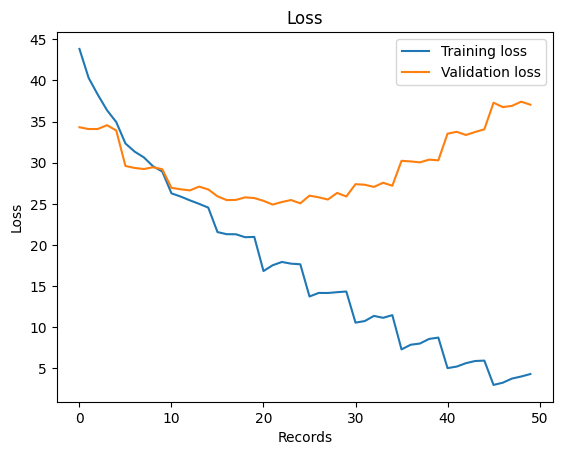

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(50, 10)


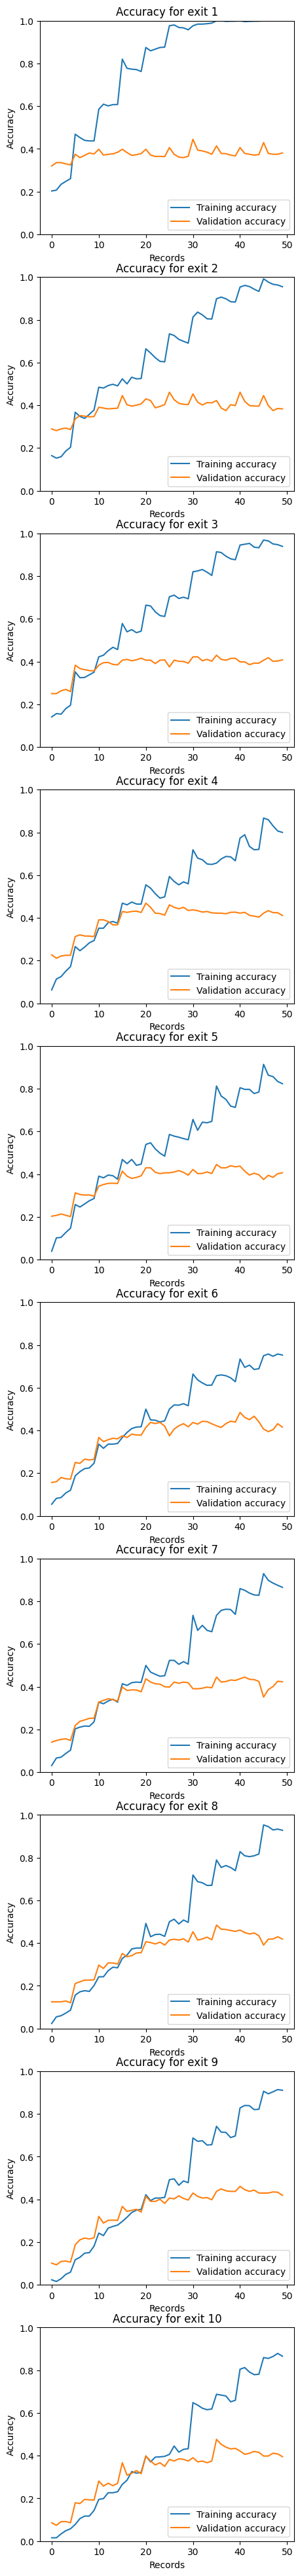

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

## Proposed algorithm for training

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:09:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Early exit decision criterion.

Based on:
- Entropy of the logits;
- Probability of the guess.

In [ ]:
def entropy(x):
    p = F.softmax(x, dim=1)
    H = -torch.mean(p * torch.log(p + 1e-8), dim=1)
    return H

In [ ]:
def find_max_prob(x):
    p = F.softmax(x, dim=1)
    return torch.max(p, dim=1).values

### Model

Function to create auxiliary branches in the network, based on the input shape of the image and the number of input channels (aka the depth of the feature map).

In [ ]:
def create_early_exit(in_shape, in_channels, num_classes):
    return nn.Sequential(
        # Convolution
        nn.Conv2d(in_channels, 128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        # Global average pooling
        # nn.AdaptiveAvgPool2d(1),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        # classifier
        nn.Linear(128 * in_shape // 2 * in_shape // 2, num_classes),
    )

In [ ]:
class BVGG13_v2(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v2, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        # create the early exit layers
        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                # evaluate the early exit
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                # compute the decision function
                H = entropy(x_ee)
                g_functions.append(H)
                e += 1
                # check if we can exit during inference phase
                if inference and torch.less(H, self.exit_threshold):
                    return x_ee, H, e

        # evaluate the final exit
        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)

        out.append(x)
        # compute the decision function
        last_H = entropy(x)
        # check if we can exit during inference phase
        if inference:
            return x, last_H, len(soft_out)

        # compute the soft-conditional output
        soft_out.append(x)

        # traverse the outputs in reverse order
        k = len(g_functions) - 1
        for o in out[-2::-1]:
            h = g_functions[k].unsqueeze(1)
            k -= 1
            f_tilde = h * o + (1 - h) * soft_out[-1]
            soft_out.append(f_tilde)

        soft_out.reverse()
        # training exit
        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:09:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   3451MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Training loop

In [ ]:
def train_model_ee_v2(
    model,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=False,
    verbose=True,
):
    n_records = 5
    check_train = len(trainloader) // n_records
    check_val = len(valloader) // n_records

    training_loss = []
    training_accuracy = []
    validation_loss = []
    validation_accuracy = []

    if early_stopping:
        early_stop = EarlyStopping(patience=5, restore_best_weights=False)

    for epoch in range(n_epochs):
        # train the model
        correct = np.zeros(len(model.early_exits) + 1)
        total = 0
        running_loss = 0
        tot_samples = 0
        model.train()
        for i, (data, target) in enumerate(trainloader):
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = model(data)
            # calculate the batch loss
            loss = loss_fn(soft_output, target)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            tot_samples += 1
            if verbose and (i + 1) % check_train == 0:
                print_str = f"Epoch {epoch + 1}\tTraining loss: {running_loss / tot_samples:.4f}"
                training_loss.append(running_loss / tot_samples)
                total += batch_size
                for i, out in enumerate(output):
                    _, pred = torch.max(out, dim=1)
                    correct[i] += (pred == target).sum().item()
                accuracy = correct / total
                training_accuracy.append(accuracy)
                accuracy = np.round(accuracy * 100, 2)
                print_str += f"\tAccuracy: {accuracy.__str__()}"
                running_loss = 0
                tot_samples = 0
                print(print_str)
            # break
        # validate the model
        with torch.no_grad():
            model.eval()
            correct = np.zeros(len(model.early_exits) + 1)
            total = 0
            running_loss = 0
            tot_samples = 0
            for i, (data, target) in enumerate(valloader):
                # move tensors to GPU if CUDA is available
                data = data.to(device)
                target = target.to(device)
                # forward pass
                output, soft_output = model(data)
                loss = loss_fn(soft_output, target).item()
                running_loss += loss
                tot_samples += 1
                if verbose and (i + 1) % check_val == 0:
                    print_str = f"Epoch {epoch + 1}\tValidation loss: {running_loss / tot_samples:.4f}"
                    validation_loss.append(running_loss / tot_samples)
                    total += batch_size
                    for i, out in enumerate(output):
                        _, pred = torch.max(out, dim=1)
                        correct[i] += (pred == target).sum().item()
                    accuracy = correct / total
                    validation_accuracy.append(accuracy)
                    accuracy = np.round(accuracy * 100, 2)
                    print_str += f"\tAccuracy: {accuracy.__str__()}"
                    running_loss = 0
                    tot_samples = 0
                    print(print_str)
        # break

        if early_stopping and early_stop(model, validation_loss[-1]):
            print(f"Stopped trained at epoch {epoch}")
            if early_stop.restore_best_weights:
                print(f"Restored model trained at epoch {epoch - early_stop.counter}")
            break

    return (
        training_loss,
        training_accuracy,
        validation_loss,
        validation_accuracy,
    )

In [ ]:
torch.manual_seed(42)
bvgg_v2 = BVGG13_v2(num_classes=100)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v2.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v2.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v2,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 45.5543	Accuracy: [0.78 3.91 3.12 6.25 3.12 4.69 1.56 1.56 0.   0.78]
Epoch 1	Training loss: 43.5456	Accuracy: [1.56 4.69 2.73 4.69 3.12 3.52 1.95 1.17 0.78 1.17]
Epoch 1	Training loss: 41.9881	Accuracy: [1.82 3.39 2.08 4.43 3.39 3.91 2.08 1.56 1.04 1.82]
Epoch 1	Training loss: 41.1189	Accuracy: [2.54 3.91 2.15 4.49 3.32 3.32 2.34 2.15 2.73 3.32]
Epoch 1	Training loss: 40.5701	Accuracy: [2.34 4.22 2.34 4.38 2.97 3.12 2.81 3.44 4.06 4.38]
Epoch 1	Validation loss: 40.3759	Accuracy: [1.56 6.25 3.91 2.34 5.47 1.56 1.56 7.81 8.59 7.81]
Epoch 1	Validation loss: 40.0990	Accuracy: [2.73 5.08 5.08 3.91 5.08 1.95 2.34 6.64 7.81 6.64]
Epoch 1	Validation loss: 39.9284	Accuracy: [2.86 4.17 4.95 4.17 5.47 2.34 1.82 5.73 7.55 7.29]
Epoch 1	Validation loss: 40.2626	Accuracy: [2.34 4.1  4.49 3.91 4.69 3.32 2.15 5.47 6.64 6.25]
Epoch 1	Validation loss: 39.8351	Accuracy: [2.5  3.44 4.22 4.22 4.38 3.44 2.66 5.31 5.94 6.56]
Epoch 2	Training loss: 39.6596	Accuracy: [2.34 5.47 1.56 4.6

### Test data

In [ ]:
# test accuracy
bvgg_v2.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v2(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 2.38%
Test took 3.19 seconds
Exit 2 test accuracy: 1.64%
Test took 3.13 seconds
Exit 3 test accuracy: 1.72%
Test took 3.82 seconds
Exit 4 test accuracy: 1.93%
Test took 4.23 seconds
Exit 5 test accuracy: 2.11%
Test took 3.24 seconds
Exit 6 test accuracy: 2.53%
Test took 3.42 seconds
Exit 7 test accuracy: 2.64%
Test took 3.88 seconds
Exit 8 test accuracy: 8.18%
Test took 4.07 seconds
Exit 9 test accuracy: 22.52%
Test took 3.21 seconds
Exit 10 test accuracy: 31.77%
Test took 3.19 seconds
the average test accuracy is 31.77


### Inference time

In [ ]:
bvgg_v2.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v2.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v2(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Entropy: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00797653 seconds
Exit: 2
Entropy: tensor([4.0573e-15])
Output: tensor([[  19.9853, -114.7156,   71.5962,   37.7706,  -43.5984,  -80.0294,
          -64.0098,    2.5684,   26.4402,  -18.3688,   -0.4076,  -88.1568,
          -89.9671,  -31.7237,  -42.0152,    3.7232,  105.1647,  -26.7340,
          -72.9684,    1.9407,  -64.3374,   56.8166,  -50.9191, -137.6545,
          -30.3856,  -23.7426,  -92.3810, -117.1885,  -13.6958,  -91.8772,
          -72.1896,  -16.7830, -135.7678,  -26.9317,  -53.0628,  -20.8748,
          -50.7036,  -51.9058,  -94.9744,  -59.8089,  -33.5973,  -48.3608,
         -109.4770,  -18.9521,  -37.5844,  -38.6584,  -14.6777, -131.8531,
          -22.5059,  -56.1796, -115.4866,    1.0669, -112.4315,  -57.2742,
          -59.7424,   22.2105,  -99.7462,    0.6182,    1.4803,  -48.0847,
         -196.0671, -104.2526, -114.2988,  -74.5668,   -2.1605,   22.0081,
          -13.6787,  -78.9165,  -72.9773,  -74.4252, -107.1631, -141.3052,
            3.7452, 

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:17:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    43W /  70W |   3453MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Learning curves

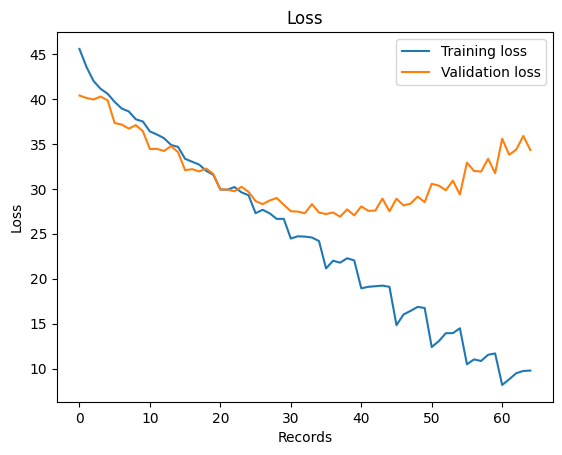

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(65, 10)


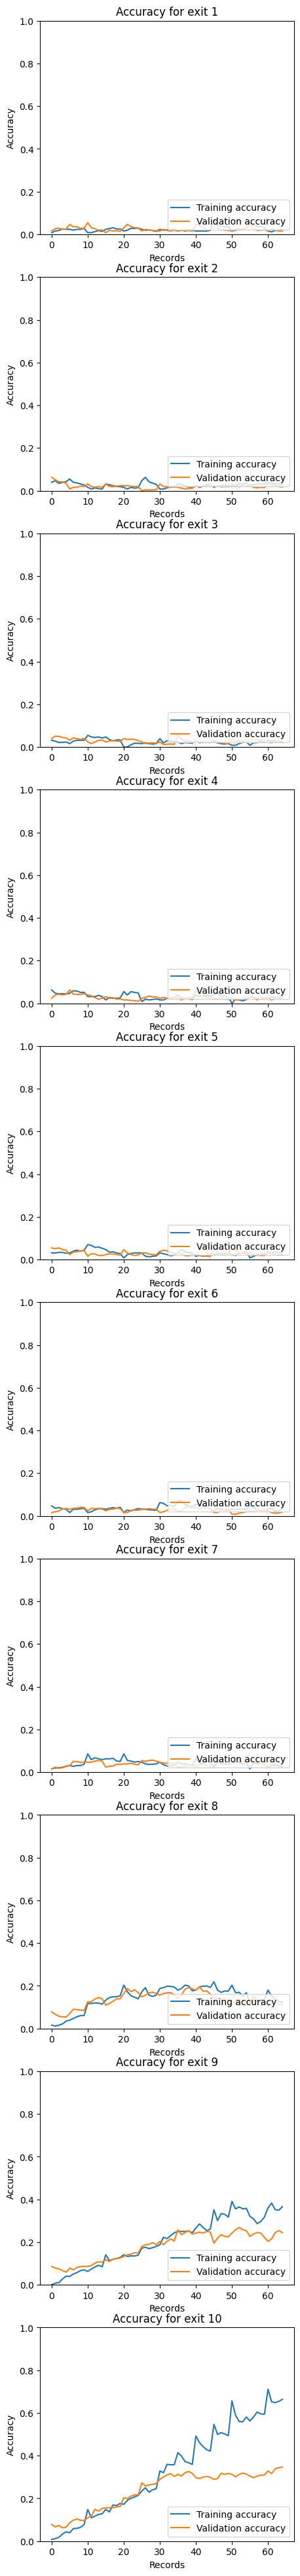

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

### Using a different decision criterion for early exit (probability of the output)

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:17:23 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    31W /  70W |   3453MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
class BVGG13_v3(nn.Module):
    def __init__(self, num_classes, batch_norm=False, dropout=False):
        super(BVGG13_v3, self).__init__()
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.set_exit_threshold(0.0)

        self.conv_layers = nn.ModuleList(
            [
                # first block
                nn.Conv2d(3, 64, kernel_size=3, padding=1),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                # second block
                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                # third block
                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                # fourth block
                nn.Conv2d(256, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                # fifth block
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
                nn.Conv2d(512, 512, kernel_size=3, padding=1),
            ]
        )

        self.pool_layers = nn.ModuleList(
            [
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Identity(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            ]
        )

        if self.batch_norm:
            self.norm_layers = nn.ModuleList(
                [
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(64),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(128),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(256),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                    nn.BatchNorm2d(512),
                ]
            )
        else:
            self.norm_layers = nn.ModuleList(
                [
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                    nn.Identity(),
                ]
            )

        if self.dropout:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                # output
                nn.Linear(4096, num_classes),
            )
        else:
            self.classifier = nn.Sequential(
                # 1st block
                nn.Linear(512 * 1 * 1, 4096),
                nn.ReLU(inplace=True),
                # 2nd block
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                # output
                nn.Linear(4096, num_classes),
            )

        self.early_exits = nn.ModuleList(
            [
                create_early_exit(32, 64, num_classes),
                create_early_exit(16, 64, num_classes),
                create_early_exit(16, 128, num_classes),
                create_early_exit(8, 128, num_classes),
                create_early_exit(8, 256, num_classes),
                create_early_exit(4, 256, num_classes),
                create_early_exit(4, 512, num_classes),
                create_early_exit(2, 512, num_classes),
                create_early_exit(2, 512, num_classes),
            ]
        )

    def forward(self, x, inference=False):
        g_functions = []
        out = []
        soft_out = []
        e = 0
        for conv, norm, pool in zip(
            self.conv_layers, self.norm_layers, self.pool_layers
        ):
            x = conv(x)
            x = norm(x)
            F.relu(x, inplace=True)
            x = pool(x)
            if e < len(self.early_exits):
                x_ee = self.early_exits[e](x)
                out.append(x_ee)
                H = find_max_prob(x_ee)
                g_functions.append(H)
                e += 1
                if inference and torch.greater(H, self.exit_threshold):
                    return x_ee, H, e

        # flatten
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        out.append(x)
        last_H = find_max_prob(x)
        if inference:
            return x, last_H, len(soft_out)

        soft_out.append(x)

        k = len(g_functions) - 1
        for i, o in enumerate(out[-2::-1]):
            h = g_functions[k].unsqueeze(1)
            k -= 1
            # print(h.shape)
            # print(o.shape)
            f_tilde = h * o + (1 - h) * soft_out[-1]
            # print("Early exit", i)
            # print(f_tilde.detach().cpu())
            soft_out.append(f_tilde)

        soft_out.reverse()

        return out, soft_out

    def set_exit_threshold(self, exit_threshold):
        self.exit_threshold = torch.tensor(exit_threshold)

In [ ]:
torch.manual_seed(42)
bvgg_v3 = BVGG13_v3(num_classes=100)
# print(vgg)
# print(check_train)
# print(check_val)

optimizer = optim.Adam(
    bvgg_v3.parameters(),
    lr=0.0005,
)

loss_fn = JointCrossEntropy()

n_epochs = 30

bvgg_v3.to(device)

start = time.time()
(
    training_loss,
    training_accuracy,
    validation_loss,
    validation_accuracy,
) = train_model_ee_v2(
    bvgg_v3,
    n_epochs,
    trainloader,
    valloader,
    optimizer,
    loss_fn,
    early_stopping=True,
    verbose=True,
)
end = time.time()
print(f"Training took {end - start:.2f} seconds")

Epoch 1	Training loss: 44.8997	Accuracy: [5.47 1.56 2.34 3.12 1.56 0.78 0.   0.78 0.78 3.12]
Epoch 1	Training loss: 42.6431	Accuracy: [9.38 3.12 5.86 1.56 1.95 0.78 0.39 0.78 1.56 2.34]
Epoch 1	Training loss: 40.9495	Accuracy: [11.46  3.39  5.99  1.82  2.6   0.78  0.52  0.78  1.3   2.08]
Epoch 1	Training loss: 39.9289	Accuracy: [14.06  3.71  8.01  2.73  2.15  0.78  0.78  0.59  1.17  2.73]
Epoch 1	Training loss: 39.2125	Accuracy: [15.47  5.    8.28  3.59  2.03  0.94  0.94  0.78  1.72  2.97]
Epoch 1	Validation loss: 38.4689	Accuracy: [22.66 14.84  7.81  5.47  1.56  3.12  1.56  1.56  3.91  5.47]
Epoch 1	Validation loss: 38.1266	Accuracy: [24.22 14.45  9.38  3.91  1.56  1.95  2.34  2.34  3.12  6.64]
Epoch 1	Validation loss: 37.9987	Accuracy: [24.74 13.54  8.59  4.17  1.56  2.08  2.08  1.56  2.34  7.03]
Epoch 1	Validation loss: 38.4297	Accuracy: [24.8  13.67  8.01  4.88  2.15  1.76  2.15  1.37  1.76  6.45]
Epoch 1	Validation loss: 37.7999	Accuracy: [23.75 12.19  8.59  4.69  2.34  1.41  2.81

### Test data

In [ ]:
# test accuracy
bvgg_v3.eval()

with torch.no_grad():
    for i in range(10):
        correct = 0
        total = 0
        start = time.time()
        for data, target in testloader:
            # move tensors to GPU if CUDA is available
            data = data.to(device)
            target = target.to(device)
            # forward pass
            output, soft_output = bvgg_v3(data, inference=False)
            # Test accuracy on the final exit
            _, pred = torch.max(output[i], dim=1)
            correct += (pred == target).sum().item()
            total += target.size(0)
        end = time.time()
        print(f"Exit {i+1} test accuracy: {correct / total * 100:.2f}%")
        print(f"Test took {end - start:.2f} seconds")
avg_acc = correct / total
print(f"the average test accuracy is {100*avg_acc}")

Exit 1 test accuracy: 35.31%
Test took 4.88 seconds
Exit 2 test accuracy: 33.14%
Test took 3.15 seconds
Exit 3 test accuracy: 37.18%
Test took 3.20 seconds
Exit 4 test accuracy: 22.92%
Test took 3.14 seconds
Exit 5 test accuracy: 37.54%
Test took 4.49 seconds
Exit 6 test accuracy: 23.73%
Test took 3.64 seconds
Exit 7 test accuracy: 28.59%
Test took 3.19 seconds
Exit 8 test accuracy: 14.43%
Test took 3.27 seconds
Exit 9 test accuracy: 10.90%
Test took 4.30 seconds
Exit 10 test accuracy: 35.51%
Test took 3.75 seconds
the average test accuracy is 35.510000000000005


### Inference time

In [ ]:
bvgg_v3.eval()
test_iter = iter(testloader)
np.random.seed(666)
for i in range(np.random.randint(len(testloader))):
    img_batch, target_batch = next(test_iter)
img_idx = np.random.randint(batch_size)
img = img_batch[img_idx]
target = target_batch[img_idx]
img = img.unsqueeze(0).to(device)

bvgg_v3.set_exit_threshold(0.5)
with torch.no_grad():
    start = time.time()
    output, H, e = bvgg_v3(img, inference=True)
    end = time.time()
    print(f"Inference time {end - start:.8f} seconds")
    print(f"Exit: {e+1}")
    print(f"Probability: {H.detach().cpu()}")
    print(f"Output: {output.detach().cpu()}")
    _, pred = torch.max(output, dim=1)
    print(f"Prediction: {classes[pred]}")
    print(f"Target: {classes[target]}")

Inference time 0.00239062 seconds
Exit: 2
Probability: tensor([0.5498])
Output: tensor([[ -7.3831, -20.5691, -14.4620,  -6.1513, -16.5687, -17.5943, -14.8484,
          -8.5970, -26.0515, -15.4809,  -5.1993, -23.7708, -16.7470, -17.9340,
         -11.6360,  -8.7603,  -1.5616, -28.2991, -10.4021, -11.9703, -20.9216,
          -2.7766, -10.4578, -30.0292, -11.0250, -15.1326, -13.2612, -21.4570,
          -9.2624, -13.4891, -25.1366, -10.9558, -12.1902, -13.8640, -14.0433,
         -12.9361, -20.1713, -18.0269, -12.3683, -13.1287, -10.8291, -14.7182,
         -19.7258, -12.8855, -12.8003, -16.1867, -13.1673, -24.9519, -15.1002,
         -29.2654, -11.8087, -18.6008, -28.8184, -17.4739, -25.0546, -12.9044,
          -7.9225,  -5.8974, -12.1620, -13.0807, -42.1917, -18.2529, -19.4099,
         -16.7260,  -7.7569,  -5.9229,  -4.7947, -18.1736, -21.9173, -23.7732,
         -22.6720, -30.6505, -11.1514, -20.7593, -10.4257, -11.8950, -20.2302,
         -10.7404,  -9.1311, -11.6821, -14.4970, -1

In [ ]:
#to check memory usage and gpu status
!nvidia-smi

Sun Nov 19 20:24:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0    43W /  70W |   3453MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

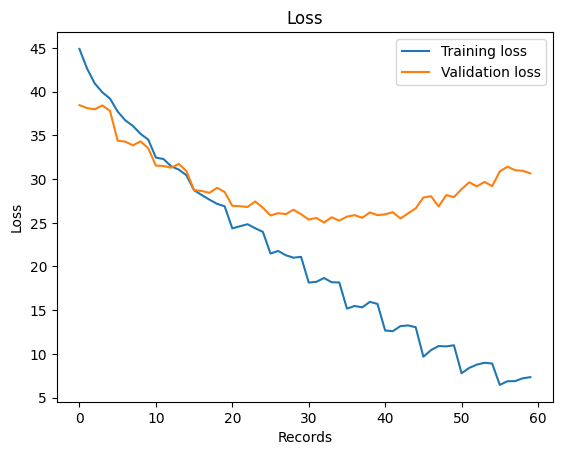

In [ ]:
plt.plot(training_loss, label="Training loss")
plt.plot(validation_loss, label="Validation loss")
plt.legend(loc="upper right")
plt.title("Loss")
plt.xlabel("Records")
plt.ylabel("Loss")
plt.show()

(60, 10)


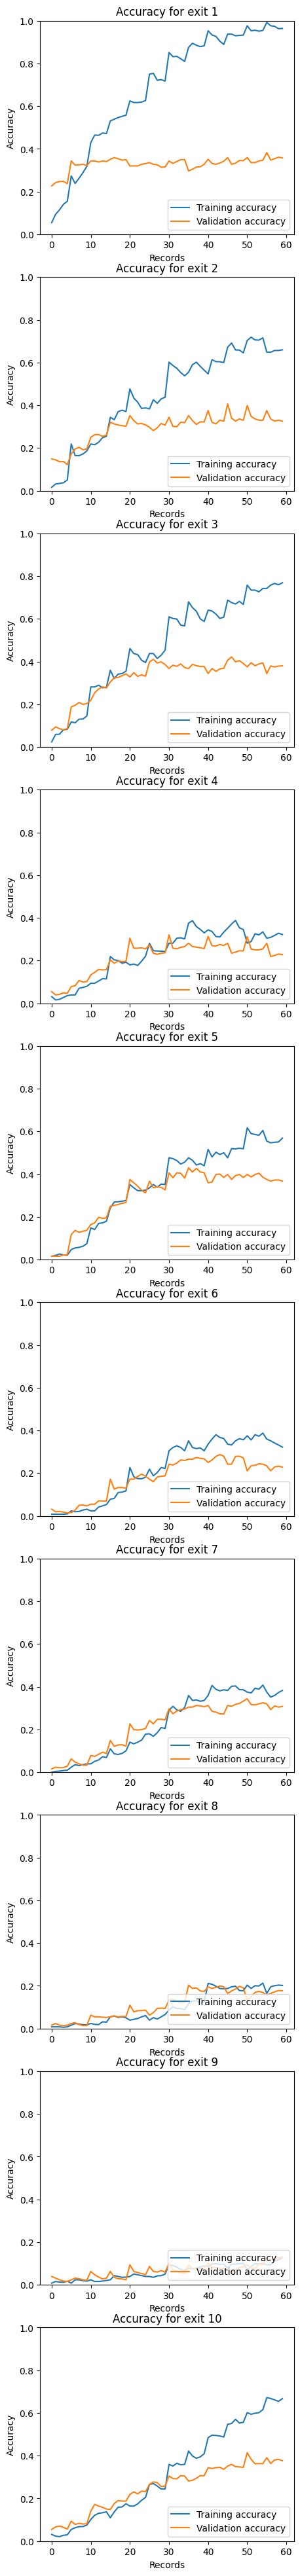

In [ ]:
training_accuracy = np.array(training_accuracy)
validation_accuracy = np.array(validation_accuracy)
print(training_accuracy.shape)
fig, axs = plt.subplots(10, 1, figsize=(5, 50))
axs = axs.flatten()
for i in range(10):
    axs[i].plot(training_accuracy[:, i], label="Training accuracy")
    axs[i].plot(validation_accuracy[:, i], label="Validation accuracy")
    axs[i].legend(loc="lower right")
    axs[i].set_title(f"Accuracy for exit {i + 1}")
    axs[i].set_xlabel("Records")
    axs[i].set_ylabel("Accuracy")
    axs[i].set_ylim([0, 1])

In [ ]:
print(f"GPU Memory Used: {humanize.naturalsize(gpu.memoryUsed)}")

GPU Memory Used: 3.5 kB
